In [11]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tensor
spikes_tensor = torch.load("tensors/spike_data_tensor.pt" ,map_location=device)
labels_tensor = torch.load("tensors/labels_tensor.pt", map_location=device)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

spikes_tensor = spikes_tensor.to(device)
labels_tensor = labels_tensor.to(device)

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [12]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset and DataLoader Configuration

In [13]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

batch_size = 32
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [14]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [15]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [60]:
import torch
import numpy as np
import random

# Reproducibility
seed = 42  

# Set seed for Python's built-in random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [62]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes (assuming a binary classification task)
n_time = 101     # Number of time steps

net = SynNet(
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

print(net)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


### Train & Validation

### Model 1 

  2%|▏         | 1/50 [00:15<12:18, 15.07s/it]

Epoch 1/50, Training Loss: 50.966981132075475, Validation Loss: 36.638392857142854


  4%|▍         | 2/50 [00:30<12:03, 15.07s/it]

Epoch 2/50, Training Loss: 36.89858490566038, Validation Loss: 33.214285714285715


  6%|▌         | 3/50 [00:45<11:47, 15.06s/it]

Epoch 3/50, Training Loss: 32.968160377358494, Validation Loss: 36.370535714285715


  8%|▊         | 4/50 [01:00<11:42, 15.28s/it]

Epoch 4/50, Training Loss: 29.619103773584907, Validation Loss: 25.732142857142858


 10%|█         | 5/50 [01:15<11:23, 15.18s/it]

Epoch 5/50, Training Loss: 26.10318396226415, Validation Loss: 24.34375


 12%|█▏        | 6/50 [01:31<11:09, 15.21s/it]

Epoch 6/50, Training Loss: 26.53007075471698, Validation Loss: 24.089285714285715


 14%|█▍        | 7/50 [01:46<10:52, 15.18s/it]

Epoch 7/50, Training Loss: 23.69575471698113, Validation Loss: 26.616071428571427


 16%|█▌        | 8/50 [02:01<10:36, 15.14s/it]

Epoch 8/50, Training Loss: 22.431603773584907, Validation Loss: 20.348214285714285


 18%|█▊        | 9/50 [02:16<10:19, 15.11s/it]

Epoch 9/50, Training Loss: 21.596698113207548, Validation Loss: 18.736607142857142


 20%|██        | 10/50 [02:31<10:06, 15.16s/it]

Epoch 10/50, Training Loss: 22.090212264150942, Validation Loss: 20.674107142857142


 22%|██▏       | 11/50 [02:46<09:52, 15.18s/it]

Epoch 11/50, Training Loss: 21.859080188679247, Validation Loss: 21.821428571428573


 24%|██▍       | 12/50 [03:01<09:35, 15.15s/it]

Epoch 12/50, Training Loss: 21.69870283018868, Validation Loss: 21.0625


 26%|██▌       | 13/50 [03:16<09:19, 15.12s/it]

Epoch 13/50, Training Loss: 20.222287735849058, Validation Loss: 24.375


 28%|██▊       | 14/50 [03:32<09:03, 15.11s/it]

Epoch 14/50, Training Loss: 21.056014150943398, Validation Loss: 25.464285714285715


 30%|███       | 15/50 [03:47<08:49, 15.13s/it]

Epoch 15/50, Training Loss: 23.670990566037737, Validation Loss: 21.089285714285715


 32%|███▏      | 16/50 [04:02<08:33, 15.12s/it]

Epoch 16/50, Training Loss: 20.379127358490567, Validation Loss: 27.879464285714285


 34%|███▍      | 17/50 [04:17<08:22, 15.22s/it]

Epoch 17/50, Training Loss: 19.85141509433962, Validation Loss: 23.879464285714285


 36%|███▌      | 18/50 [04:32<08:06, 15.20s/it]

Epoch 18/50, Training Loss: 18.878537735849058, Validation Loss: 24.433035714285715


 38%|███▊      | 19/50 [04:48<07:50, 15.18s/it]

Epoch 19/50, Training Loss: 20.56191037735849, Validation Loss: 18.508928571428573


 40%|████      | 20/50 [05:03<07:34, 15.16s/it]

Epoch 20/50, Training Loss: 19.652712264150942, Validation Loss: 19.611607142857142


 42%|████▏     | 21/50 [05:18<07:19, 15.16s/it]

Epoch 21/50, Training Loss: 20.434551886792452, Validation Loss: 18.138392857142858


 44%|████▍     | 22/50 [05:33<07:03, 15.11s/it]

Epoch 22/50, Training Loss: 18.15625, Validation Loss: 18.334821428571427


 46%|████▌     | 23/50 [05:48<06:48, 15.11s/it]

Epoch 23/50, Training Loss: 18.066627358490567, Validation Loss: 20.084821428571427


 48%|████▊     | 24/50 [06:03<06:33, 15.14s/it]

Epoch 24/50, Training Loss: 17.836674528301888, Validation Loss: 17.964285714285715


 50%|█████     | 25/50 [06:19<06:20, 15.23s/it]

Epoch 25/50, Training Loss: 17.31191037735849, Validation Loss: 20.03125


 52%|█████▏    | 26/50 [06:34<06:05, 15.21s/it]

Epoch 26/50, Training Loss: 17.19575471698113, Validation Loss: 18.941964285714285


 54%|█████▍    | 27/50 [06:49<05:50, 15.23s/it]

Epoch 27/50, Training Loss: 18.17570754716981, Validation Loss: 16.066964285714285


 56%|█████▌    | 28/50 [07:04<05:32, 15.10s/it]

Epoch 28/50, Training Loss: 16.994103773584907, Validation Loss: 19.571428571428573


 58%|█████▊    | 29/50 [07:19<05:17, 15.10s/it]

Epoch 29/50, Training Loss: 17.004127358490567, Validation Loss: 17.169642857142858


 60%|██████    | 30/50 [07:35<05:05, 15.28s/it]

Epoch 30/50, Training Loss: 17.610259433962263, Validation Loss: 17.424107142857142


 62%|██████▏   | 31/50 [07:50<04:51, 15.35s/it]

Epoch 31/50, Training Loss: 17.13502358490566, Validation Loss: 25.15625


 64%|██████▍   | 32/50 [08:05<04:35, 15.29s/it]

Epoch 32/50, Training Loss: 17.43632075471698, Validation Loss: 17.799107142857142


 66%|██████▌   | 33/50 [08:21<04:20, 15.30s/it]

Epoch 33/50, Training Loss: 16.98997641509434, Validation Loss: 19.232142857142858


 68%|██████▊   | 34/50 [08:36<04:06, 15.38s/it]

Epoch 34/50, Training Loss: 16.77889150943396, Validation Loss: 18.455357142857142


 70%|███████   | 35/50 [08:51<03:50, 15.37s/it]

Epoch 35/50, Training Loss: 16.89504716981132, Validation Loss: 18.933035714285715


 72%|███████▏  | 36/50 [09:07<03:34, 15.33s/it]

Epoch 36/50, Training Loss: 16.34198113207547, Validation Loss: 16.004464285714285


 74%|███████▍  | 37/50 [09:22<03:18, 15.25s/it]

Epoch 37/50, Training Loss: 17.80070754716981, Validation Loss: 17.321428571428573


 76%|███████▌  | 38/50 [09:37<03:02, 15.19s/it]

Epoch 38/50, Training Loss: 16.298349056603772, Validation Loss: 15.8125


 78%|███████▊  | 39/50 [09:52<02:47, 15.26s/it]

Epoch 39/50, Training Loss: 18.24056603773585, Validation Loss: 17.59375


 80%|████████  | 40/50 [10:08<02:33, 15.31s/it]

Epoch 40/50, Training Loss: 16.830188679245282, Validation Loss: 17.03125


 82%|████████▏ | 41/50 [10:23<02:18, 15.34s/it]

Epoch 41/50, Training Loss: 16.721698113207548, Validation Loss: 17.553571428571427


 84%|████████▍ | 42/50 [10:39<02:02, 15.37s/it]

Epoch 42/50, Training Loss: 15.830778301886792, Validation Loss: 21.46875


 86%|████████▌ | 43/50 [10:54<01:46, 15.26s/it]

Epoch 43/50, Training Loss: 18.06485849056604, Validation Loss: 23.785714285714285


 88%|████████▊ | 44/50 [11:09<01:31, 15.19s/it]

Epoch 44/50, Training Loss: 16.5, Validation Loss: 21.964285714285715


 90%|█████████ | 45/50 [11:24<01:16, 15.24s/it]

Epoch 45/50, Training Loss: 16.545990566037737, Validation Loss: 16.589285714285715


 92%|█████████▏| 46/50 [11:39<01:00, 15.13s/it]

Epoch 46/50, Training Loss: 15.76061320754717, Validation Loss: 18.263392857142858


 94%|█████████▍| 47/50 [11:54<00:45, 15.09s/it]

Epoch 47/50, Training Loss: 16.09551886792453, Validation Loss: 17.245535714285715


 96%|█████████▌| 48/50 [12:09<00:30, 15.12s/it]

Epoch 48/50, Training Loss: 15.89681603773585, Validation Loss: 19.830357142857142


 98%|█████████▊| 49/50 [12:24<00:15, 15.11s/it]

Epoch 49/50, Training Loss: 15.409787735849056, Validation Loss: 15.732142857142858


100%|██████████| 50/50 [12:39<00:00, 15.19s/it]

Epoch 50/50, Training Loss: 16.83254716981132, Validation Loss: 17.441964285714285


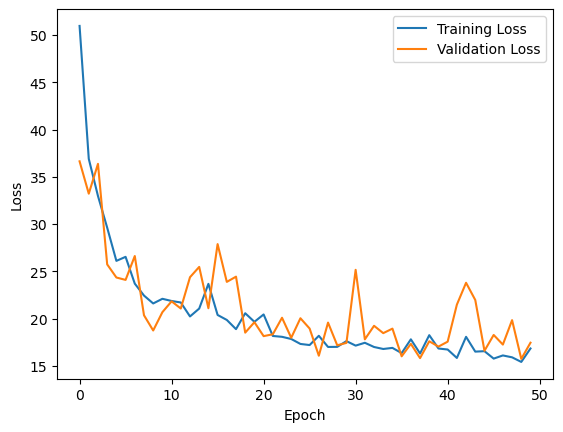

In [63]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials and spikes
membrane_potentials = []
spike_outputs = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        # Compute loss
        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Access internal layer membrane potentials and spikes
        # Save the `v_mem` and spikes from all neuron layers
        for lyr_name in net.lif_names:
            lyr = net.seq[lyr_name]
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
    
    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = net(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


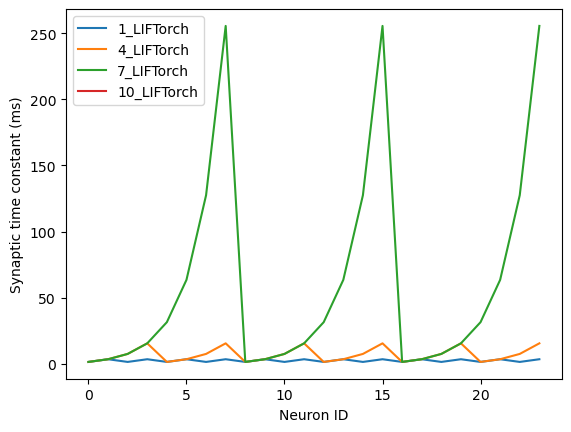

In [65]:
import matplotlib.pyplot as plt

# Plot synaptic time constants for each LIF layer
for lyr_name in net.lif_names:
    tau_syn = net.seq[lyr_name].tau_syn.detach().cpu().numpy() / 1e-3  # Convert to ms
    plt.plot(tau_syn, label=f"{lyr_name}")
    
plt.xlabel("Neuron ID")
plt.ylabel("Synaptic time constant (ms)")
plt.legend()
plt.show()


### Model 1 Visualization

- Visualization across network

In [66]:
import numpy as np

# Pad the output layer's membrane potentials to match the shape of the hidden layers
padded_potentials = []
for potentials in membrane_potentials:
    if potentials.shape == (24,):
        padded_potentials.append(potentials)
    elif potentials.shape == (1,):
        padded_potentials.append(np.repeat(potentials, 24))  # Repeat to match the shape (24,)

padded_potentials = np.array(padded_potentials)


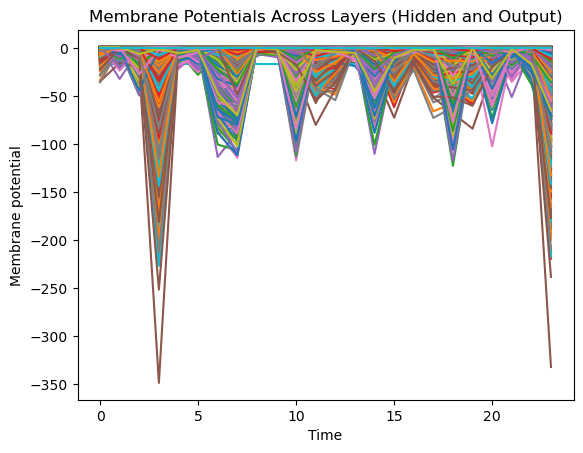

In [67]:
plt.plot(padded_potentials.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title("Membrane Potentials Across Layers (Hidden and Output)")
plt.show()


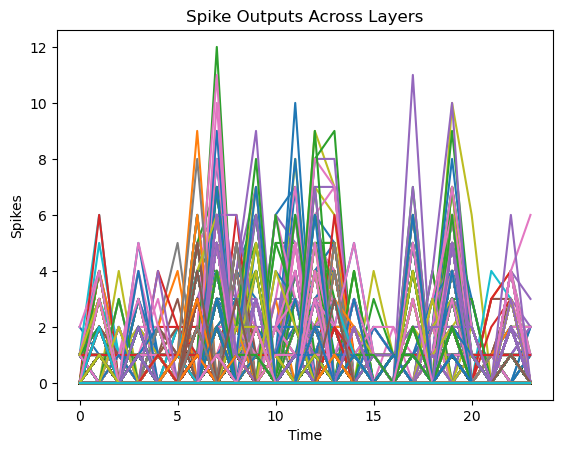

In [68]:
padded_spikes = []
for spikes in spike_outputs:
    if spikes.shape == (24,):
        padded_spikes.append(spikes)
    elif spikes.shape == (1,):
        padded_spikes.append(np.repeat(spikes, 24)) 

padded_spikes = np.array(padded_spikes)

plt.plot(padded_spikes.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title("Spike Outputs Across Layers")
plt.show()


- Visualization of specific layers

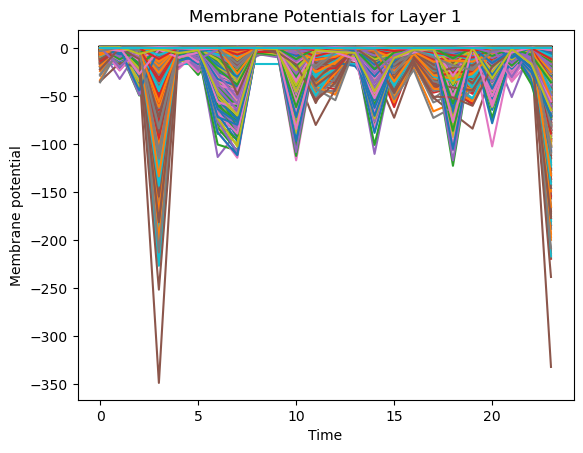

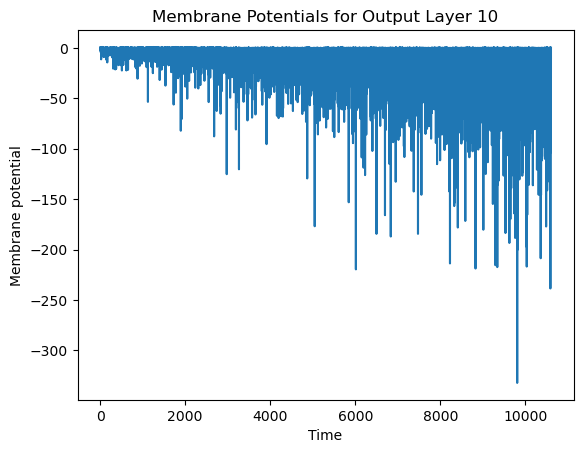

In [69]:
# Plot membrane potentials for the first hidden layer and output layer
layer_to_plot_hidden = 1  # First hidden layer
layer_to_plot_output = 10  # Output layer

# Membrane potential for first hidden layer
mem_pot_hidden_layer = padded_potentials[:, :24]  # First 24 neurons for the hidden layer
plt.plot(mem_pot_hidden_layer.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title(f"Membrane Potentials for Layer {layer_to_plot_hidden}")
plt.show()

# Membrane potential for output layer (last layer)
mem_pot_output_layer = padded_potentials[:, -1]  # Output layer (single neuron, repeated 24 times for plotting)
plt.plot(mem_pot_output_layer.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title(f"Membrane Potentials for Output Layer {layer_to_plot_output}")
plt.show()


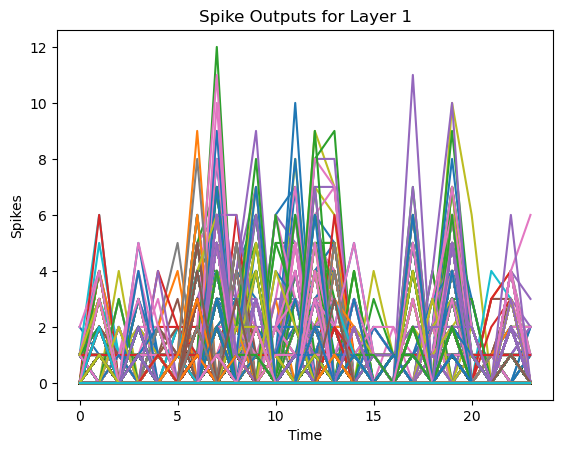

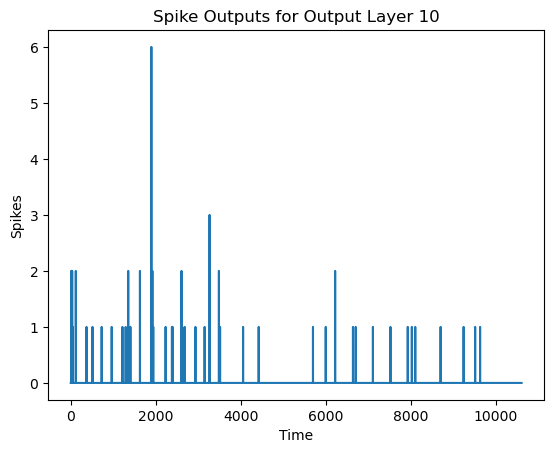

In [70]:
# Spike outputs for first hidden layer
spike_hidden_layer = padded_spikes[:, :24]  # First 24 neurons for the hidden layer
plt.plot(spike_hidden_layer.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title(f"Spike Outputs for Layer {layer_to_plot_hidden}")
plt.show()

# Spike outputs for output layer (last layer)
spike_output_layer = padded_spikes[:, -1]  # Output layer (single neuron, repeated 24 times for plotting)
plt.plot(spike_output_layer.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title(f"Spike Outputs for Output Layer {layer_to_plot_output}")
plt.show()


- Visualization on a smaller time range (allows for better visualization of how spikes occur within a few time steps)

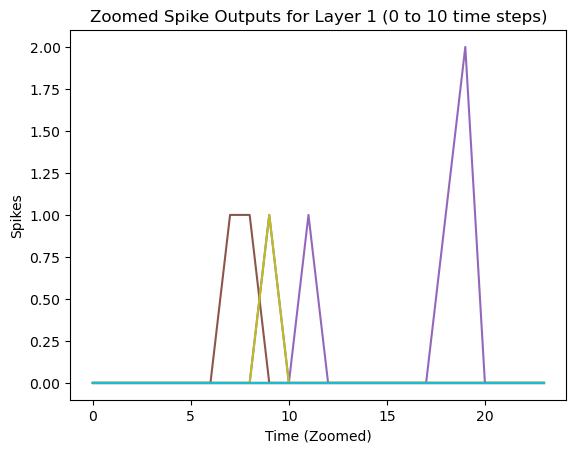

In [71]:
# Zoom in on first 10 time steps for the first hidden layer (spike outputs)
zoomed_time_range = 10  # First 10 time steps
spike_hidden_layer_zoomed = padded_spikes[:zoomed_time_range, :24]  # First 24 neurons for the hidden layer
plt.plot(spike_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Spikes")
plt.title(f"Zoomed Spike Outputs for Layer {layer_to_plot_hidden} (0 to {zoomed_time_range} time steps)")
plt.show()


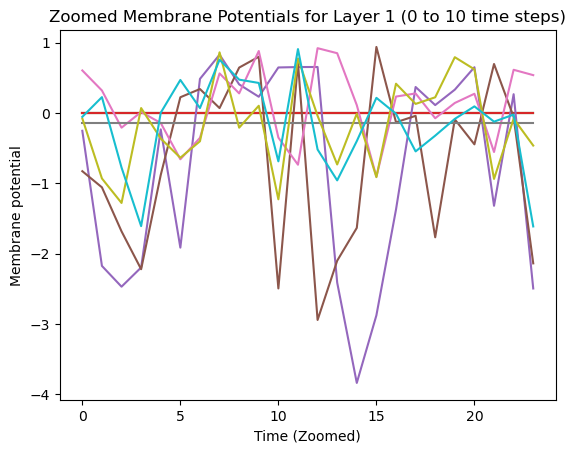

In [72]:
# Zoom in on first 10 time steps for the first hidden layer (membrane potentials)
mem_pot_hidden_layer_zoomed = padded_potentials[:zoomed_time_range, :24]  # First 24 neurons for the hidden layer
plt.plot(mem_pot_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Membrane potential")
plt.title(f"Zoomed Membrane Potentials for Layer {layer_to_plot_hidden} (0 to {zoomed_time_range} time steps)")
plt.show()


- Visualization of comparison of inputs and outputs

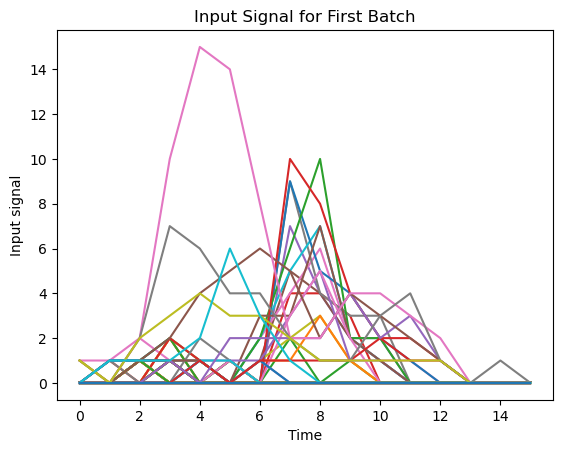

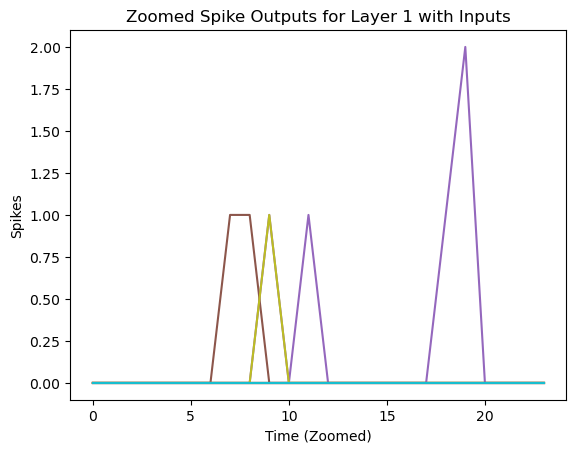

In [73]:
plt.plot(inputs[0, :, :].detach().cpu().numpy().T)  
plt.xlabel("Time")
plt.ylabel("Input signal")
plt.title("Input Signal for First Batch")
plt.show()

# compare with spike and membrane potential from one of the hidden layers
plt.plot(spike_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Spikes")
plt.title(f"Zoomed Spike Outputs for Layer {layer_to_plot_hidden} with Inputs")
plt.show()


### Model 2
- Added dropout of 0.1

In [16]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101     

net = SynNet(
    p_dropout = 0.1,
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


  2%|▏         | 1/50 [00:15<12:45, 15.63s/it]

Epoch 1/50, Training Loss: 68.28478773584905, Validation Loss: 84.68303571428571


  4%|▍         | 2/50 [00:31<12:29, 15.61s/it]

Epoch 2/50, Training Loss: 63.6998820754717, Validation Loss: 186.6875


  6%|▌         | 3/50 [00:46<11:59, 15.31s/it]

Epoch 3/50, Training Loss: 48.84375, Validation Loss: 141.19642857142858


  8%|▊         | 4/50 [01:01<11:37, 15.16s/it]

Epoch 4/50, Training Loss: 44.22405660377358, Validation Loss: 81.41071428571429


 10%|█         | 5/50 [01:16<11:28, 15.30s/it]

Epoch 5/50, Training Loss: 37.613207547169814, Validation Loss: 48.263392857142854


 12%|█▏        | 6/50 [01:31<11:10, 15.25s/it]

Epoch 6/50, Training Loss: 34.4498820754717, Validation Loss: 31.053571428571427


 14%|█▍        | 7/50 [01:47<10:56, 15.27s/it]

Epoch 7/50, Training Loss: 31.794811320754718, Validation Loss: 40.78125


 16%|█▌        | 8/50 [02:02<10:36, 15.16s/it]

Epoch 8/50, Training Loss: 30.776533018867923, Validation Loss: 26.0625


 18%|█▊        | 9/50 [02:17<10:20, 15.13s/it]

Epoch 9/50, Training Loss: 30.73938679245283, Validation Loss: 42.142857142857146


 20%|██        | 10/50 [02:32<10:09, 15.25s/it]

Epoch 10/50, Training Loss: 28.682783018867923, Validation Loss: 30.3125


 22%|██▏       | 11/50 [02:47<09:53, 15.22s/it]

Epoch 11/50, Training Loss: 27.39445754716981, Validation Loss: 20.575892857142858


 24%|██▍       | 12/50 [03:02<09:37, 15.19s/it]

Epoch 12/50, Training Loss: 28.194575471698112, Validation Loss: 22.910714285714285


 26%|██▌       | 13/50 [03:17<09:20, 15.14s/it]

Epoch 13/50, Training Loss: 27.59316037735849, Validation Loss: 39.129464285714285


 28%|██▊       | 14/50 [03:33<09:04, 15.13s/it]

Epoch 14/50, Training Loss: 27.193396226415093, Validation Loss: 21.276785714285715


 30%|███       | 15/50 [03:48<08:49, 15.13s/it]

Epoch 15/50, Training Loss: 26.09492924528302, Validation Loss: 22.866071428571427


 32%|███▏      | 16/50 [04:04<08:46, 15.47s/it]

Epoch 16/50, Training Loss: 25.944575471698112, Validation Loss: 25.3125


 34%|███▍      | 17/50 [04:20<08:33, 15.55s/it]

Epoch 17/50, Training Loss: 24.190448113207548, Validation Loss: 22.40625


 36%|███▌      | 18/50 [04:34<08:10, 15.34s/it]

Epoch 18/50, Training Loss: 23.192806603773583, Validation Loss: 19.415178571428573


 38%|███▊      | 19/50 [04:50<07:53, 15.28s/it]

Epoch 19/50, Training Loss: 23.19575471698113, Validation Loss: 18.848214285714285


 40%|████      | 20/50 [05:05<07:35, 15.17s/it]

Epoch 20/50, Training Loss: 22.912146226415093, Validation Loss: 20.397321428571427


 42%|████▏     | 21/50 [05:20<07:19, 15.16s/it]

Epoch 21/50, Training Loss: 22.972287735849058, Validation Loss: 25.285714285714285


 44%|████▍     | 22/50 [05:35<07:04, 15.17s/it]

Epoch 22/50, Training Loss: 21.39327830188679, Validation Loss: 18.544642857142858


 46%|████▌     | 23/50 [05:50<06:51, 15.22s/it]

Epoch 23/50, Training Loss: 21.03242924528302, Validation Loss: 21.321428571428573


 48%|████▊     | 24/50 [06:05<06:35, 15.22s/it]

Epoch 24/50, Training Loss: 21.43573113207547, Validation Loss: 17.303571428571427


 50%|█████     | 25/50 [06:20<06:18, 15.13s/it]

Epoch 25/50, Training Loss: 21.110259433962263, Validation Loss: 18.995535714285715


 52%|█████▏    | 26/50 [06:36<06:05, 15.23s/it]

Epoch 26/50, Training Loss: 20.70577830188679, Validation Loss: 23.183035714285715


 54%|█████▍    | 27/50 [06:51<05:49, 15.21s/it]

Epoch 27/50, Training Loss: 22.493514150943398, Validation Loss: 17.5


 56%|█████▌    | 28/50 [07:06<05:32, 15.12s/it]

Epoch 28/50, Training Loss: 21.336674528301888, Validation Loss: 34.013392857142854


 58%|█████▊    | 29/50 [07:21<05:16, 15.07s/it]

Epoch 29/50, Training Loss: 24.40507075471698, Validation Loss: 26.4375


 60%|██████    | 30/50 [07:36<04:58, 14.95s/it]

Epoch 30/50, Training Loss: 23.94811320754717, Validation Loss: 20.517857142857142


 62%|██████▏   | 31/50 [07:50<04:42, 14.85s/it]

Epoch 31/50, Training Loss: 22.52358490566038, Validation Loss: 17.558035714285715


 64%|██████▍   | 32/50 [08:05<04:29, 14.95s/it]

Epoch 32/50, Training Loss: 21.80483490566038, Validation Loss: 17.513392857142858


 66%|██████▌   | 33/50 [08:20<04:15, 15.01s/it]

Epoch 33/50, Training Loss: 20.10554245283019, Validation Loss: 22.049107142857142


 68%|██████▊   | 34/50 [08:36<04:01, 15.07s/it]

Epoch 34/50, Training Loss: 19.316627358490567, Validation Loss: 17.125


 70%|███████   | 35/50 [08:51<03:48, 15.26s/it]

Epoch 35/50, Training Loss: 20.10259433962264, Validation Loss: 20.308035714285715


 72%|███████▏  | 36/50 [09:07<03:33, 15.28s/it]

Epoch 36/50, Training Loss: 20.67629716981132, Validation Loss: 20.308035714285715


 74%|███████▍  | 37/50 [09:22<03:19, 15.32s/it]

Epoch 37/50, Training Loss: 19.26002358490566, Validation Loss: 19.004464285714285


 76%|███████▌  | 38/50 [09:37<03:03, 15.26s/it]

Epoch 38/50, Training Loss: 19.74174528301887, Validation Loss: 17.776785714285715


 78%|███████▊  | 39/50 [09:52<02:46, 15.17s/it]

Epoch 39/50, Training Loss: 21.952240566037737, Validation Loss: 18.602678571428573


 80%|████████  | 40/50 [10:08<02:32, 15.22s/it]

Epoch 40/50, Training Loss: 20.090212264150942, Validation Loss: 16.125


 82%|████████▏ | 41/50 [10:22<02:15, 15.10s/it]

Epoch 41/50, Training Loss: 20.6061320754717, Validation Loss: 17.299107142857142


 84%|████████▍ | 42/50 [10:37<02:00, 15.08s/it]

Epoch 42/50, Training Loss: 19.732900943396228, Validation Loss: 25.870535714285715


 86%|████████▌ | 43/50 [10:53<01:47, 15.29s/it]

Epoch 43/50, Training Loss: 21.315448113207548, Validation Loss: 33.513392857142854


 88%|████████▊ | 44/50 [11:10<01:34, 15.80s/it]

Epoch 44/50, Training Loss: 21.755896226415093, Validation Loss: 19.46875


 90%|█████████ | 45/50 [11:27<01:20, 16.04s/it]

Epoch 45/50, Training Loss: 23.31485849056604, Validation Loss: 21.71875


 92%|█████████▏| 46/50 [11:43<01:04, 16.11s/it]

Epoch 46/50, Training Loss: 21.972877358490567, Validation Loss: 22.071428571428573


 94%|█████████▍| 47/50 [12:00<00:48, 16.32s/it]

Epoch 47/50, Training Loss: 21.39563679245283, Validation Loss: 19.9375


 96%|█████████▌| 48/50 [12:17<00:32, 16.48s/it]

Epoch 48/50, Training Loss: 22.85436320754717, Validation Loss: 17.066964285714285


 98%|█████████▊| 49/50 [12:33<00:16, 16.34s/it]

Epoch 49/50, Training Loss: 19.911556603773583, Validation Loss: 20.129464285714285


100%|██████████| 50/50 [12:48<00:00, 15.37s/it]

Epoch 50/50, Training Loss: 20.60672169811321, Validation Loss: 20.25


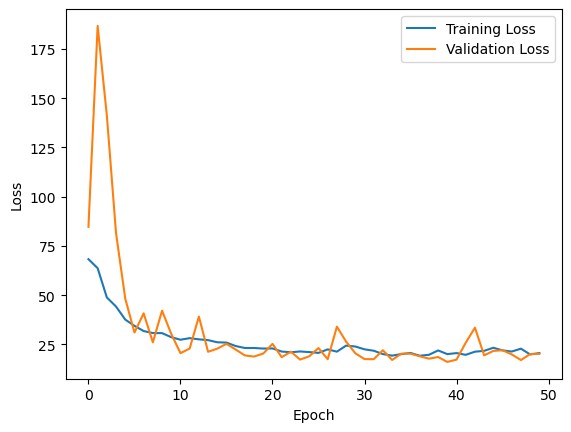

In [10]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials and spikes
membrane_potentials = []
spike_outputs = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        # Compute loss
        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Access internal layer membrane potentials and spikes
        # Save the `v_mem` and spikes from all neuron layers
        for lyr_name in net.lif_names:
            lyr = net.seq[lyr_name]
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
    
    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = net(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Hyperparameters
n_epochs = 50
learning_rate = 1e-3

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = CrossEntropyLoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

# Track all predictions and true labels
all_outputs = []
all_labels = []

# Validation phase
net.eval()
val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        val_loss += loss.item()

        # Collect predictions and true labels
        all_outputs.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()

# Convert to numpy for metric calculations
y_pred_proba = all_outputs.numpy()
y_true = all_labels.numpy()

val_losses.append(val_loss / len(val_loader))

print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


100%|██████████| 50/50 [10:35<00:00, 12.72s/it]


Epoch 50/50, Training Loss: 0.42144895836992086, Validation Loss: 0.43861060057367596


Validation Accuracy: 0.89
ROC-AUC Score: 0.86


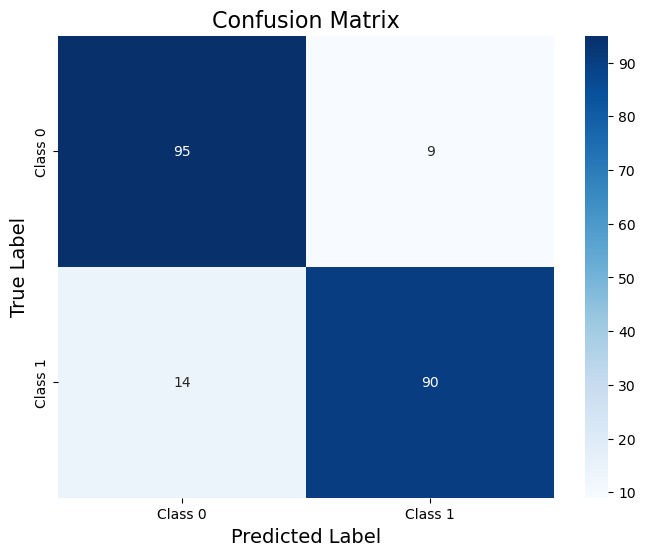

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns


# Get the predicted class by taking the argmax (highest probability)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])  # Use probabilities for the positive class
print(f"ROC-AUC Score: {roc_auc:.2f}")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],  # Adjust labels according to your classes
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



In [28]:
#generate classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.87      0.91      0.89       104
     Class 1       0.91      0.87      0.89       104

    accuracy                           0.89       208
   macro avg       0.89      0.89      0.89       208
weighted avg       0.89      0.89      0.89       208

